# Dogs vs Cats with Keras
---

# Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
PATH = "../data/dogscats/dogscats/"
sz=224
batch_size=64

In [4]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input

/home/ainsteinx/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [71]:
import matplotlib.pyplot as plt


# Load Data

In [34]:
train_data_dir = f'{PATH}train'
validation_data_dir = f'{PATH}valid'

In [19]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [20]:
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(sz, sz),
                                                    batch_size=batch_size, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir, shuffle=False, target_size=(sz, sz),
                                                        batch_size=batch_size, class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Build Model 

In [21]:
base_model = ResNet50(weights='imagenet', include_top=False)

94658560/94653016 [==============================] - 12s 0us/step


In [24]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [25]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [26]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model

In [27]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=3, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/3
359/359 [==============================] - 254s 707ms/step - loss: 0.1787 - acc: 0.9486 - val_loss: 0.0590 - val_acc: 0.9834
Epoch 2/3
359/359 [==============================] - 207s 576ms/step - loss: 0.0854 - acc: 0.9705 - val_loss: 0.0873 - val_acc: 0.9793
Epoch 3/3
359/359 [==============================] - 207s 576ms/step - loss: 0.0670 - acc: 0.9766 - val_loss: 0.0652 - val_acc: 0.9859
CPU times: user 24min 34s, sys: 1min 24s, total: 25min 59s
Wall time: 11min 7s


In [30]:
len(model.layers)

178

In [31]:
split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])    

In [33]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=1, workers=3,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/1
359/359 [==============================] - 263s 733ms/step - loss: 0.0779 - acc: 0.9739 - val_loss: 0.2162 - val_acc: 0.9718
CPU times: user 9min 54s, sys: 38.2 s, total: 10min 33s
Wall time: 4min 25s


# Model Evaluation

In [36]:
test_data_dir = f'{PATH}valid'

In [37]:
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(sz,sz),
                                                  batch_size=batch_size, class_mode='binary')

Found 2000 images belonging to 2 classes.


In [38]:
test_generator.n

2000

In [53]:
sample_x, sample_y = test_generator.next()


In [54]:
sample_x.shape, sample_y.shape

((64, 224, 224, 3), (64,))

In [56]:
sample_pred = model.predict(x=sample_x, batch_size=32, verbose=1)

64/64 [==============================] - 1s 18ms/step


In [57]:
acc = np.array(sample_pred==sample_y)

In [61]:
sample_pred.shape, sample_y.shape

((64, 1), (64,))

In [86]:
sample_pred = sample_pred.astype(int).flatten()

In [93]:
acc = (sample_pred == sample_y)

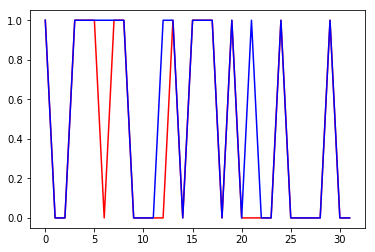

In [91]:
fig, ax = plt.subplots()
ax.plot(sample_pred[:32].astype(int), c='r')
ax.plot(sample_y[:32], c='b')

In [95]:
acc.mean()

0.921875